# Procedimiento programa

Lo primero que se realizo en el programa fue llamar a las librerias

In [17]:
# -*- coding: utf-8 -*-
"""
Created on Mon May 16 20:26:29 2022

@author: ianja
"""
import serial
import numpy as np 
from scipy.signal import butter, lfilter
import neurokit2 as nk
import pandas as pd
import pymysql as my
from tensorflow import keras
import joblib
import matplotlib.pyplot as plt


Continuando se inicial el proceso de comunicacion serial pyserial para posteriormente recibir los dato codificados del dispositivo 

Se declaran las variables y listas para la adquisicion de variables y se realizaon dos filtros para el preprocesamiento de las señales que muestran a continuacion 

In [23]:
m_ECG=[]
deltha=[]
low_alpha=[]
high_alpha=[]

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

Para la adquiscion de predictores para el arbol de decision lo que se realizo fue lo calcular lo siguiente: 

In [25]:
def car_EEG(signal):
    signal = np.array(signal)
    a=nk.entropy_sample(signal)
    b=nk.entropy_approximate(signal)
    c=nk.entropy_fuzzy(signal)
    d=nk.fractal_correlation(signal)
    e=nk.entropy_shannon(signal)
    f=nk.fractal_dfa(signal, overlap=False, rms=True)
    return a,b,c,d,e,f

Este capítulo presenta el algoritmo de entropía de muestra (SampEn) como un método alternativo para la estimación de entropía en datos del mundo real. La entropía difusa se diferencia de la entropía de Shannon clásica en cuanto la entropía difusa contiene incertidumbres difusas (posibilista), mientras que la entropía de Shannon contiene incertidumbres con aleatoriedad (probabilística). Y la aproximada es una medida de la complejidad de los sistemas caóticos, basada en el cálculo rápido de la aleatoriedad de una serie temporal de datos no lineales; también la utilizó para predecir señales o valores sucesivos de datos

<img src="https://www.fieldtriptoolbox.org/assets/img/example/entropy_analysis/Figure2.png" alt="drawing" width="500"/>


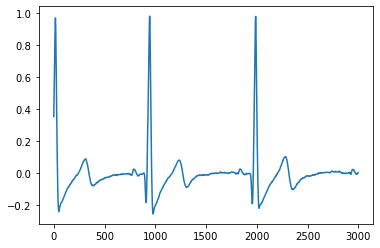

In [45]:
signal=nk.data(dataset="ecg_3000hz")
plt.plot(signal[0:3000])
plt.show()

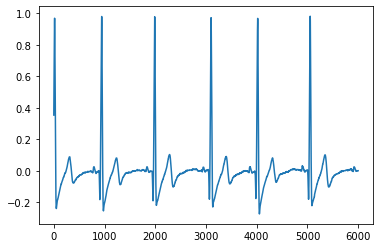

In [46]:
signal=nk.data(dataset="ecg_3000hz")
plt.plot(signal[0:6000])
plt.show()

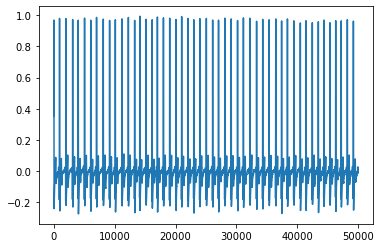

In [47]:
plt.plot(signal)
plt.show()

C:\Users\ianja\anaconda3\lib\site-packages\pandas\core\frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


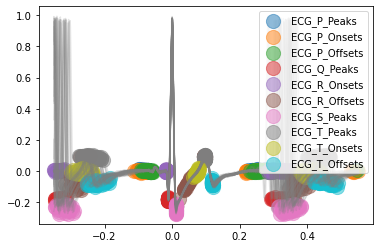

In [48]:
_, rpeaks = nk.ecg_peaks(signal, sampling_rate=3000)

# Delineate
signal, waves = nk.ecg_delineate(signal, rpeaks, sampling_rate=3000, method="dwt", show=True, show_type='all')

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,1060.020964,83.466138,36.602126,76.783897,17.685523,81.692637,NaN,NaN,64.451467,64.519189,...,1.689328,4.989563,1.255956,1.751363,1.328535,2.373092,1.549972,1.892273,3.50486,0.876727


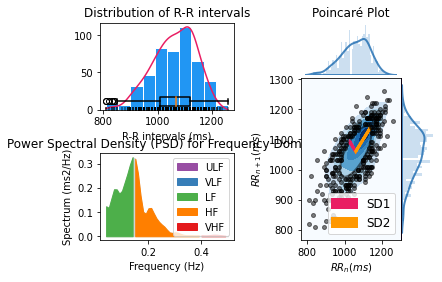

In [52]:
data = nk.data("bio_resting_8min_100hz")
peaks, info = nk.ecg_peaks(data["ECG"], sampling_rate=100)
nk.hrv(peaks, sampling_rate=100, show=True)

In [9]:
import pandas as pd
import numpy as np
import os
import sklearn.pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

def root_directory():
    current_path = os.path.abspath(__file__)
    return os.path.abspath(os.path.join(current_path, os.pardir))
def data_directory():
    return os.path.join(root_directory(), "data")

def load_train_set():
    in_file = os.path.join(data_directory(), "final",  "train.csv")
    return pd.read_csv(in_file)
def load_test_set():
    in_file = os.path.join(data_directory(), "final",  "test.csv")
    return pd.read_csv(in_file)

def simple_model_evaluation():
    select = SelectKBest(k=20)
    train =load_train_set()
    test = load_test_set()
    target = 'condition'
    hrv_features = list(train)
    hrv_features = [x for x in hrv_features if x not in [target]]
    X_train= train[hrv_features]
    y_train= train[target]
    X_test = test[hrv_features]
    y_test = test[target]
    classifiers = [
                    RandomForestClassifier(n_estimators=100, max_features='log2', n_jobs=-1),
                    SVC(C=20, kernel='rbf'),   
                 ]
    for clf in classifiers:
        name = str(clf).split('(')[0]
        if 'svc' == name.lower():
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        clf = RandomForestClassifier()
        steps = [('feature_selection', select),
             ('model', clf)]
        pipeline = sklearn.pipeline.Pipeline(steps)
        pipeline.fit(X_train, y_train)
        y_prediction = pipeline.predict(X_test)
        print("----------------------------{0}---------------------------".format(name))
        print(sklearn.metrics.classification_report(y_test, y_prediction))
        print()
        print()

<img src="resultado.PNG">

Datos antes del preprocesamiento 

Datos despues del preprocesamiento 

In [28]:
#Primer ejemplo 
deltha= np.load('Ejemplo 1/deltha.npy')
low_alpha= np.load('Ejemplo 1/low_alpha.npy')
high_alpha= np.load('Ejemplo 1/high_alpha.npy')
m_ECG= np.load('Ejemplo 1/m_ECG.npy')

In [58]:
#Segundo ejemplo 
deltha= np.load('Ejemplo 2/deltha.npy')
low_alpha= np.load('Ejemplo 2/low_alpha.npy')
high_alpha= np.load('Ejemplo 2/high_alpha.npy')
m_ECG= np.load('Ejemplo 2/m_ECG.npy')

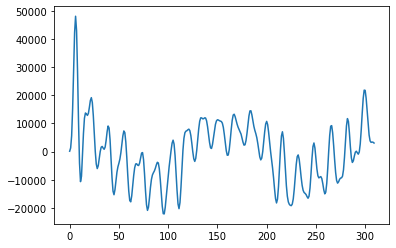

In [59]:
plt.plot(deltha)
plt.show()

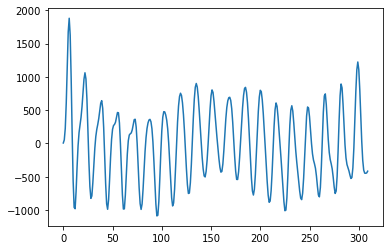

In [60]:
plt.plot(low_alpha)
plt.show()

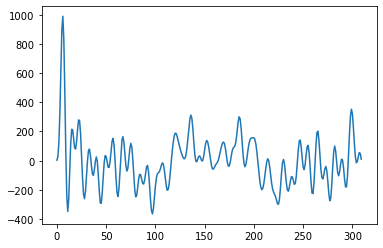

In [61]:
plt.plot(high_alpha)
plt.show()

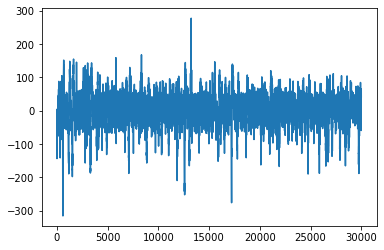

In [62]:
plt.plot(m_ECG)
plt.show()

Modelo de arbol de decision 

In [49]:
data = pd.DataFrame({"ECG" : m_ECG}) 
data = data.squeeze()
processed_data, info = nk.bio_process(data, sampling_rate=200)
results = nk.bio_analyze(processed_data, sampling_rate=200)
ecg_car1=[results['ECG_Rate_Mean'][0] , results['HRV_MeanNN'][0], results['HRV_PAS'][0], results['HRV_MCVNN'][0],results['HRV_SampEn'][0], results['HRV_MFDFA_alpha1_Width'][0]]
# ecg_car=[1.23,0.8,0.65,0.54,0.55,0.78]
clf3 = joblib.load("decision_arbol.pkl")

Resultado de aplicacion 

In [50]:
ecg_car=[ecg_car1]
ecg_car = np.array(ecg_car)
y=clf3.predict(ecg_car)     
ecg_car1.append(int(y[0]))
print(y)


[1.]


Modelo de autoencoder

In [55]:
a0,b0,c0,d0,e0,f0=car_EEG(deltha)
eeg_carac1=[a0[0],b0[0],c0[0],d0[0],e0[0],f0[0]]
# eeg_carac=[1.23,0.8,0.65,0.54,0.55,0.78]
model1 = keras.models.load_model('save_autoencoder/')
eeg_carac=[eeg_carac1]
eeg_carac = np.array(eeg_carac)
X_pred = model1.predict(eeg_carac)
ecm = np.mean((eeg_carac-X_pred)**2)
umbral_fijo = 0.065
y =1 if ecm > umbral_fijo else 0; 
print(X_pred.shape)
print(y)
eeg_carac1.append(y)

1/1 [==============================] - 0s 141ms/step
(1, 6)
1


Modelo K means para segmentar 

In [56]:
clf2 = joblib.load("modelo_kmeans.pkl")
# a=(1,2,3,4,5,6,7)
# b=(1,2,3,4,5,6,7)
# ecg_car=[a+b]
ecg_car=[eeg_carac1+ecg_car1]
ecg_car = np.array(ecg_car)
y=clf2.predict(ecg_car)
print(y)
eeg_carac1.append(int(y))
ecg_car1.append(int(y))

[1]


Guardar datos en base 

In [57]:
try:
    connection= my.connect(
        host="localhost",
        user="root",
        password="118Schwester118",
        db="registro_EEG_ECG")
    
    cursor= connection.cursor()
    sql="INSERT INTO EEG(Sample_D,Aprox_D,Fuzzy_D,Corre_D,Shannon_D,DFA_D,y,cluster) VALUES(%s, %s, %s, %s,%s, %s, %s, %s)"
    cursor.execute(sql,eeg_carac1)
    sql="INSERT INTO ECG(HR,MEDIAN_RR,LF,MEDIAN_REL_RR,SAMPEN,PNN50,y,cluster) VALUES(%s, %s, %s, %s,%s, %s, %s, %s)"
    cursor.execute(sql,ecg_car1)
    connection.commit()
    print("Registro exitoso SQL daatabase")

except my.Error as error:
    print("Failed to insert into MySQL table {}".format(error))
    connection.commit()

Registro exitoso SQL daatabase
